# Todo
- Remove more features from 47 to get desired 35 
- Create 3 more models then use stacking method to predict houses in each group
- Validate each model. 
- Create the test data prediction function and transform the test data then predict using the best model

In [85]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import csv
import locale
from scipy.stats import randint
import joblib
locale.setlocale( locale.LC_ALL, '' )

'English_United States.1252'

In [86]:
def safe_log(x):
    return np.log(x + 1e-10)
#chat gpt

In [87]:
x = 0.0
result = np.log(x)  # This will result in a warning or an error
# Compare with safe_log
safe_result = safe_log(x)  # This will not result in errors
print(result, safe_result)

-inf -23.025850929940457


C:\Users\Superuser\AppData\Local\Temp\ipykernel_6956\3585201358.py:2: RuntimeWarning: divide by zero encountered in log
  result = np.log(x)  # This will result in a warning or an error


In [88]:
train_set = pd.read_csv("train.csv")
test_set = pd.read_csv("test.csv")

In [89]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1022 non-null   int64  
 1   Id             1022 non-null   int64  
 2   MSSubClass     1022 non-null   int64  
 3   MSZoning       1022 non-null   object 
 4   LotFrontage    842 non-null    float64
 5   LotArea        1022 non-null   int64  
 6   Street         1022 non-null   object 
 7   Alley          60 non-null     object 
 8   LotShape       1022 non-null   object 
 9   LandContour    1022 non-null   object 
 10  Utilities      1022 non-null   object 
 11  LotConfig      1022 non-null   object 
 12  LandSlope      1022 non-null   object 
 13  Neighborhood   1022 non-null   object 
 14  Condition1     1022 non-null   object 
 15  Condition2     1022 non-null   object 
 16  BldgType       1022 non-null   object 
 17  HouseStyle     1022 non-null   object 
 18  OverallQ

In [90]:
housing = train_set.copy()

In [91]:
all_data_na = (housing.isnull().sum() / len(housing)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(15)

,Missing Ratio
PoolQC,99.510763
MiscFeature,96.868885
Alley,94.129159
Fence,80.626223
MasVnrType,60.078278
FireplaceQu,46.966732
LotFrontage,17.612524
GarageType,5.283757
GarageYrBlt,5.283757
GarageFinish,5.283757


We fill the missing values by 0 if the type of the input is an integer, and we fill ‘None’ if it’s categorical.

In [92]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
    housing[col] = housing[col].fillna(0)
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass' ):
    housing[col] = housing[col].fillna('None')

For the following input variables, we fill the missing values with the most frequent value. Notice that the variable LotFrontage is of type “float”. In general, the LotFrontage of a house is more or less equal to the Neighborhood houses. Hence we group the data by “Neighborhood” and fill the missing values with a median value of the neighborhood houses.

In [93]:
housing["LotFrontage"] = housing.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
housing['MSZoning'] = housing['MSZoning'].fillna(housing['MSZoning'].mode()[0])
housing['Electrical'] = housing['Electrical'].fillna(housing['Electrical'].mode()[0])
housing['KitchenQual'] = housing['KitchenQual'].fillna(housing['KitchenQual'].mode()[0])
housing['Exterior1st'] = housing['Exterior1st'].fillna(housing['Exterior1st'].mode()[0])
housing['Exterior2nd'] = housing['Exterior2nd'].fillna(housing['Exterior2nd'].mode()[0])
housing['SaleType'] = housing['SaleType'].fillna(housing['SaleType'].mode()[0])

In [94]:
#almost all of Utilities is the same
housing = housing.drop(['Utilities'], axis=1)
#replace missing values with "Typ"
housing["Functional"] = housing["Functional"].fillna("Typ")
#combine features
housing['TotalSF'] = housing['TotalBsmtSF'] + housing['1stFlrSF'] + housing['2ndFlrSF']
# dropped because overfitting
housing = housing.drop("Id", axis=1)
# considered irrelevant from histograms (too many 0 values)
housing = housing.drop("MSZoning", axis=1) 
housing = housing.drop("YrSold", axis=1) 
housing = housing.drop("LowQualFinSF", axis=1)
#Too many missing values
housing = housing.drop("PoolQC", axis=1)
housing = housing.drop("Fence", axis=1)
housing = housing.drop("MiscFeature", axis=1)
housing = housing.drop("FireplaceQu", axis=1)
housing = housing.drop("Alley", axis=1)

# changes to data

corr_matrix = housing.corr(numeric_only=True)
list_col = list(corr_matrix)
corr_matrix["SalePrice"]


Unnamed: 0      -0.035452
MSSubClass      -0.076696
LotFrontage      0.344844
LotArea          0.257302
OverallQual      0.789634
OverallCond     -0.083465
YearBuilt        0.542773
YearRemodAdd     0.510283
MasVnrArea       0.469071
BsmtFinSF1       0.398335
BsmtFinSF2      -0.004278
BsmtUnfSF        0.218188
TotalBsmtSF      0.612676
1stFlrSF         0.611725
2ndFlrSF         0.308750
GrLivArea        0.719985
BsmtFullBath     0.226761
BsmtHalfBath    -0.015511
FullBath         0.570163
HalfBath         0.284235
BedroomAbvGr     0.175139
KitchenAbvGr    -0.132590
TotRmsAbvGrd     0.555989
Fireplaces       0.475610
GarageYrBlt      0.260569
GarageCars       0.634395
GarageArea       0.626319
WoodDeckSF       0.308526
OpenPorchSF      0.317960
EnclosedPorch   -0.128401
3SsnPorch        0.032842
ScreenPorch      0.103018
PoolArea         0.116425
MiscVal         -0.029293
MoSold           0.060779
SalePrice        1.000000
TotalSF          0.785196
Name: SalePrice, dtype: float64

In [95]:
#no more missing values
all_data_na = (housing.isnull().sum() / len(housing)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


# collinearity

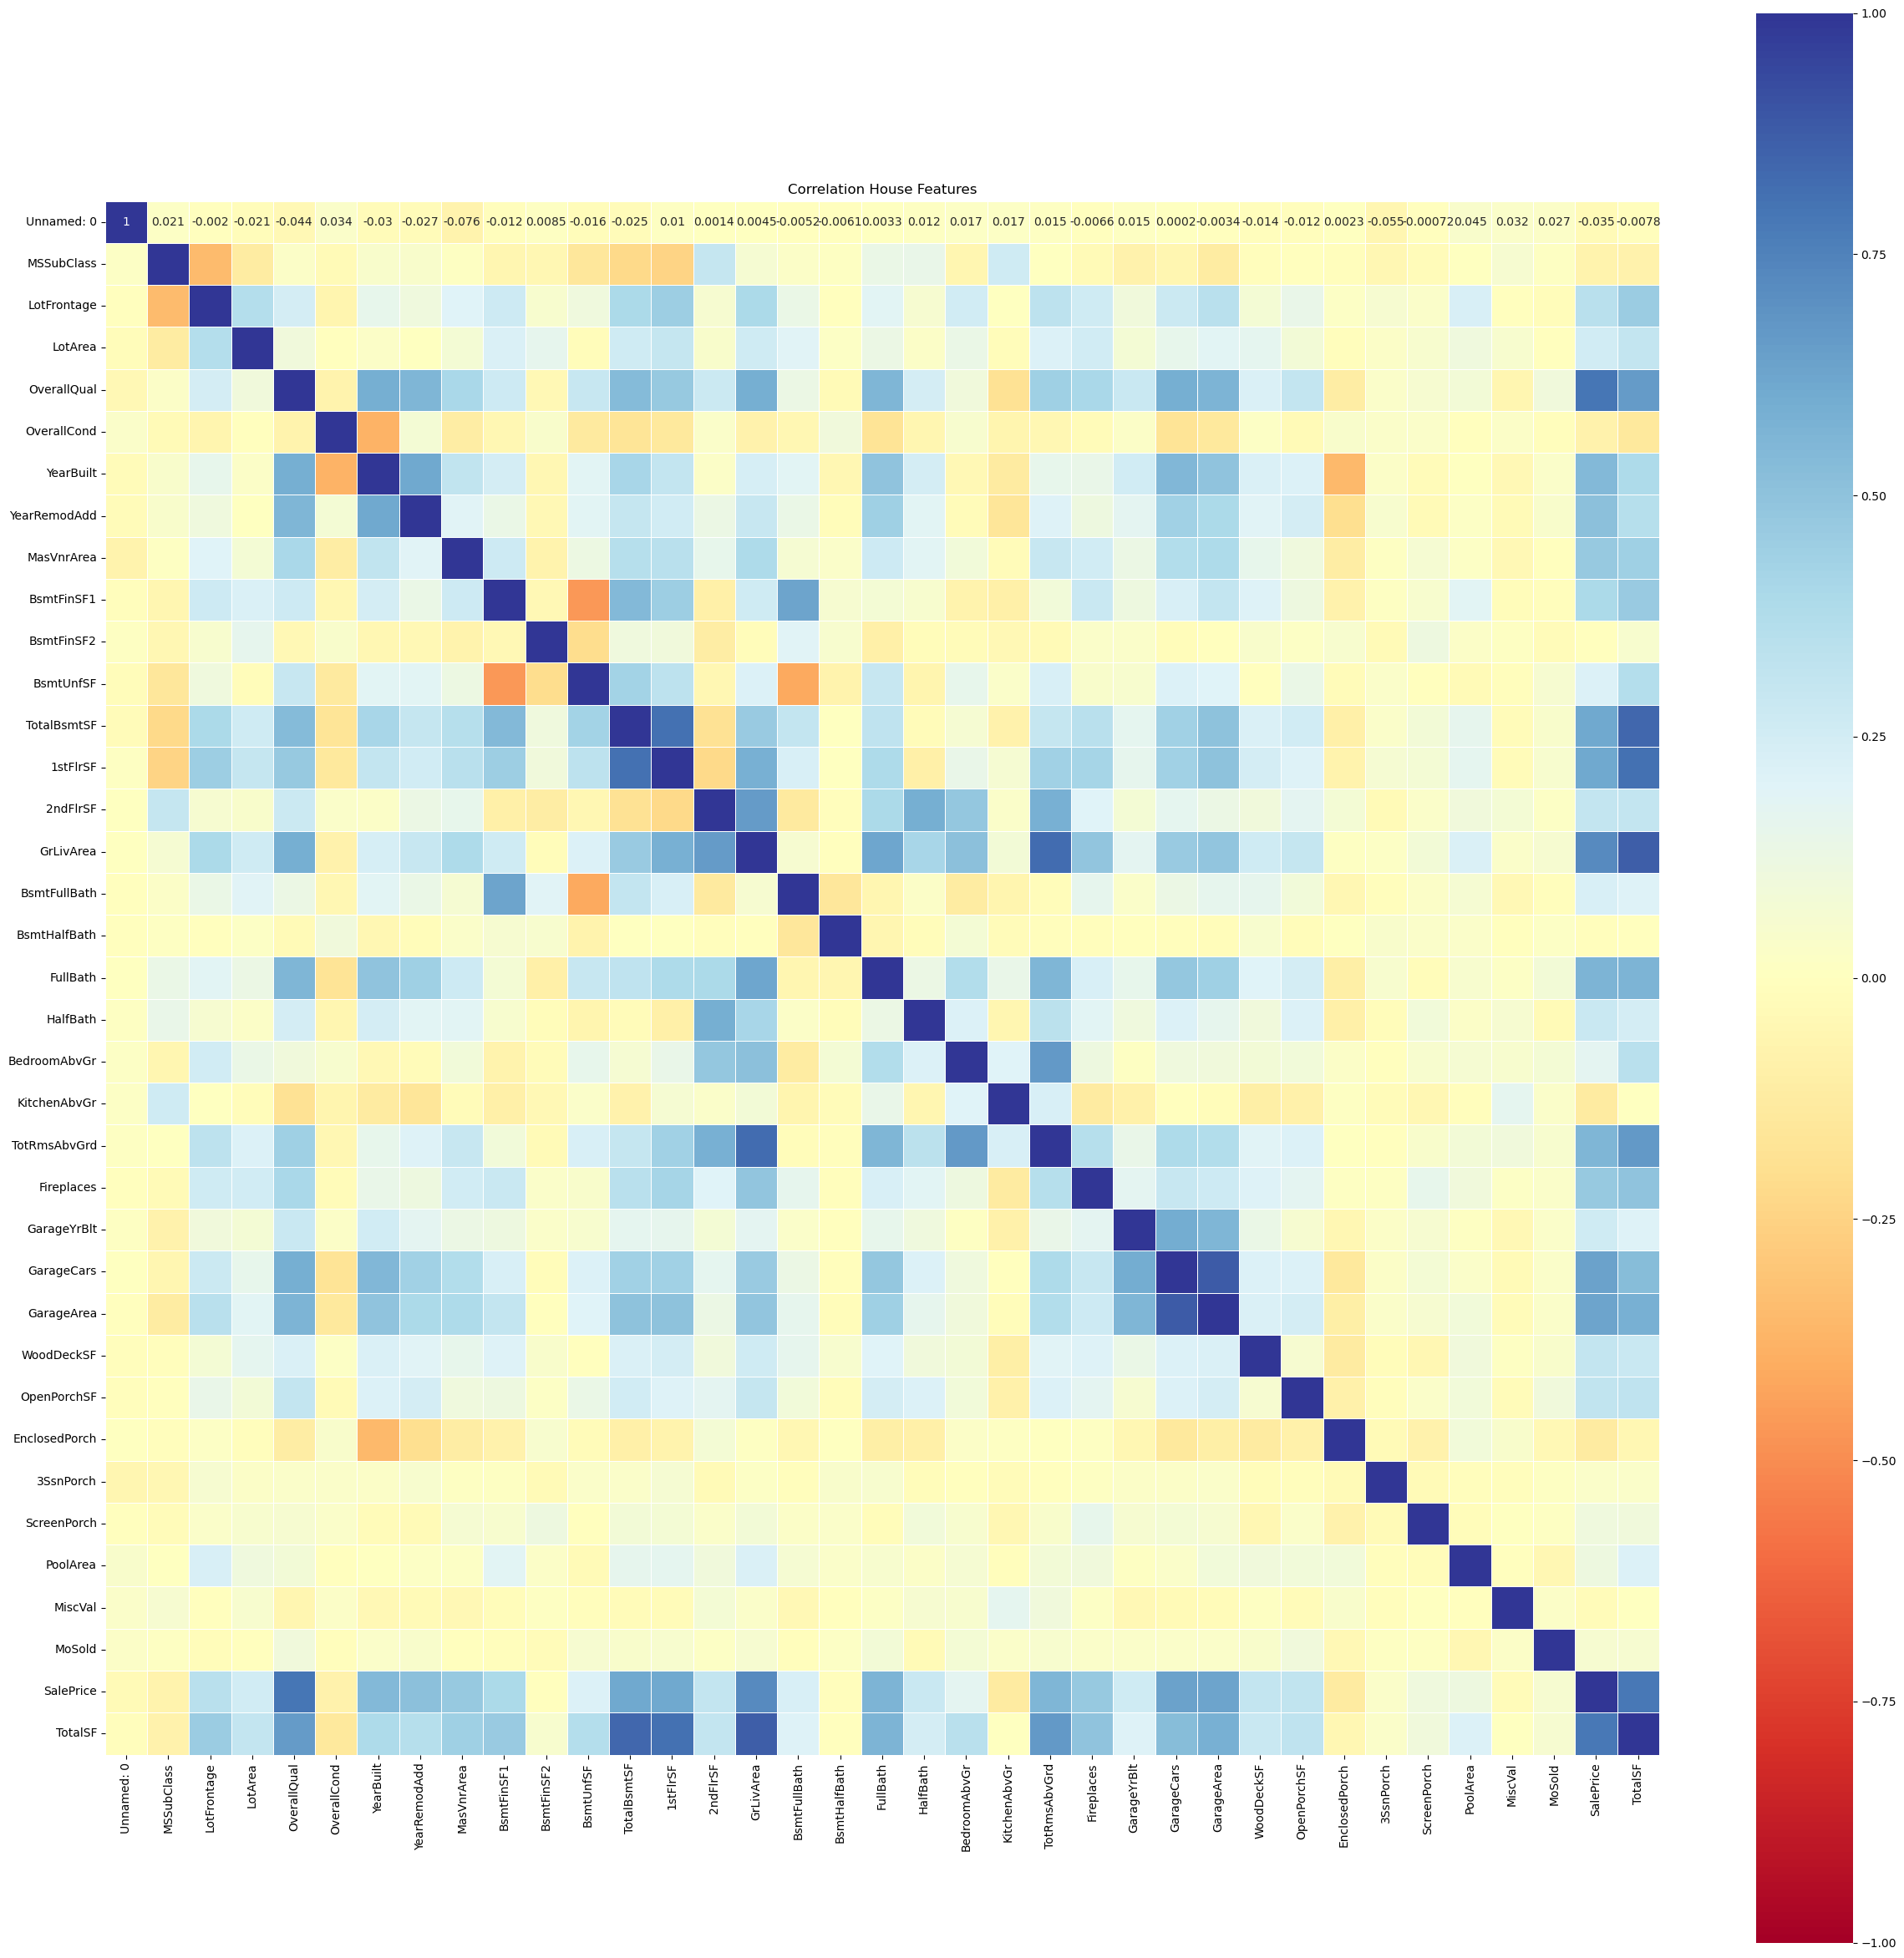

In [96]:
#Get dataframe of only numberic columns
import matplotlib.pyplot as plt 
import seaborn as sns
dfnumeric = housing._get_numeric_data()
corrmat = dfnumeric.corr()

f, ax = plt.subplots(figsize = (30,30))
sns.heatmap(corrmat, vmin = -1, vmax = 1, square=True, annot = True, cmap = 'RdYlBu', linewidths =.5)
plt.title('Correlation House Features')

plt.show();

# Outliers

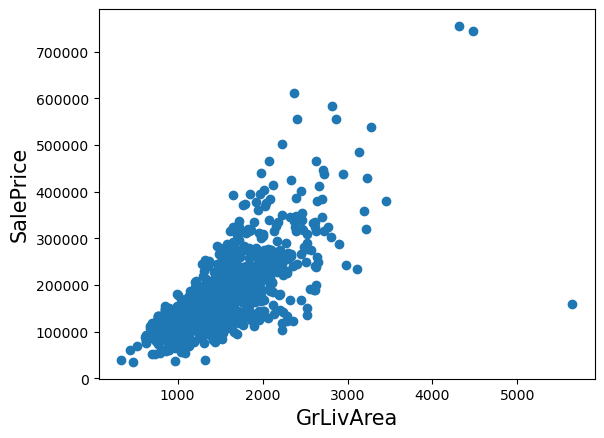

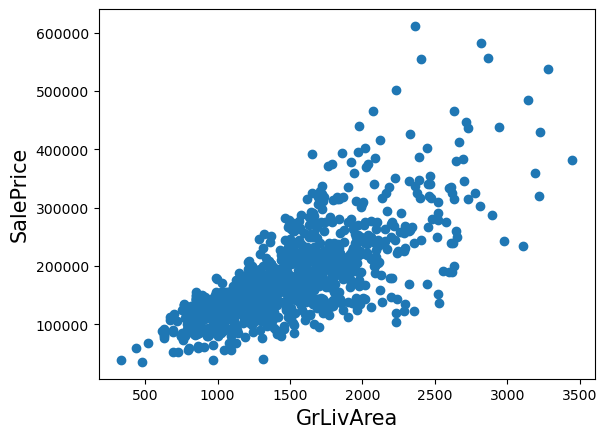

In [97]:

fig, ax = plt.subplots()
ax.scatter(x = housing['GrLivArea'], y = housing['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()


# Replace outliers with the mean of "GrLivArea" excluding outliers
mean_grlivarea = np.median(housing.loc[housing['GrLivArea'] <= 4000, 'GrLivArea'])
housing.loc[housing['GrLivArea'] > 4000, 'GrLivArea'] = mean_grlivarea
# Replace outliers in 'SalePrice' with the median of 'SalePrice' excluding outliers
median_saleprice = np.median(housing.loc[housing['SalePrice'] <= 700000, 'SalePrice'])
housing.loc[housing['SalePrice'] > 700000, 'SalePrice'] = median_saleprice
        
fig, ax = plt.subplots()
ax.scatter(x = housing['GrLivArea'], y = housing['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

# Cleaning Data

dropping all values with lower than 0.5 correlation leaves us with 47 values

In [98]:
housing_labels = pd.DataFrame(train_set["SalePrice"].copy())
housing = housing.drop("SalePrice", axis=1)
ids = test_set["Id"]
#drop cols with <0.5 correlation
for k in range(len(list_col)):
    if corr_matrix["SalePrice"].iloc[k] < 0.5:
        housing = housing.drop(f"{list_col[k]}", axis=1)
list(housing.columns)

['Street',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'TotalBsmtSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'KitchenQual',
 'TotRmsAbvGrd',
 'Functional',
 'GarageType',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'TotalSF']

In [99]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 47 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Street         1022 non-null   object
 1   LotShape       1022 non-null   object
 2   LandContour    1022 non-null   object
 3   LotConfig      1022 non-null   object
 4   LandSlope      1022 non-null   object
 5   Neighborhood   1022 non-null   object
 6   Condition1     1022 non-null   object
 7   Condition2     1022 non-null   object
 8   BldgType       1022 non-null   object
 9   HouseStyle     1022 non-null   object
 10  OverallQual    1022 non-null   int64 
 11  YearBuilt      1022 non-null   int64 
 12  YearRemodAdd   1022 non-null   int64 
 13  RoofStyle      1022 non-null   object
 14  RoofMatl       1022 non-null   object
 15  Exterior1st    1022 non-null   object
 16  Exterior2nd    1022 non-null   object
 17  MasVnrType     1022 non-null   object
 18  ExterQual      1022 non-null

Use one hot encoder for categorical features then use standard scaler for numerical features to make them between 0-1 as well. 

In [100]:
text_pipeline = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
num_norm_pipeline = make_pipeline(StandardScaler())
preprocess = ColumnTransformer([
    ("text", text_pipeline, make_column_selector(dtype_include=object))],
    remainder=num_norm_pipeline
)

# Classifier K means

In [101]:
from sklearn.cluster import KMeans
# Classifier pipeline (k-means)
k_means_pipeline = Pipeline([
    ('preprocess', preprocess),
    ('kmeans', KMeans())
])
# Parameters for grid search
param_grid = {
    'kmeans__n_clusters': [2, 3, 4, 5],  #range of clusters
}
#Grid search with k-fold cross-validation
grid_search = GridSearchCV(k_means_pipeline, param_grid, cv=5)  # Adjust cv as needed
#Fit the pipeline with grid search on your data
grid_search.fit(housing, housing_labels)
#Access the best parameters and the fitted model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print(best_params)

c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

KeyboardInterrupt: 

In [ ]:
# KMeans pipeline
k_means_pipeline = make_pipeline(preprocess, KMeans(n_clusters=5))  

# Fit KMeans and get cluster assignments
cluster_assignments = k_means_pipeline.fit_predict(housing)

# Add cluster assignments to the original DataFrame
housing_clustered = pd.concat([housing, pd.Series(cluster_assignments, name='Cluster')], axis=1)

# Print the DataFrame with cluster assignments
print(housing_clustered['Cluster'])

c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

0       1
1       3
2       0
3       1
4       3
       ..
1017    0
1018    0
1019    3
1020    0
1021    3
Name: Cluster, Length: 1022, dtype: int32


# Linear Regression

In [ ]:
import locale

# Set the locale
locale.setlocale(locale.LC_ALL, '')
# Linear regression pipeline
lin_reg_pipeline = make_pipeline(preprocess, LinearRegression())
# Loop through each cluster
for i in range(5):  # Assuming 5 clusters
    # Filter data for the current cluster
    cluster_data = housing_clustered[housing_clustered['Cluster'] == i]
    X_cluster = cluster_data.drop(columns=['Cluster'])  # Features for the current cluster
    y_cluster = housing_labels.loc[cluster_data.index]  # Replace 'your_target_column' with your actual target column
    
    # Fit the linear regression model for the current cluster
    lin_reg_pipeline.fit(X_cluster, y_cluster)

    # Make predictions for the entire dataset
    housing_predictions = lin_reg_pipeline.predict(housing)
    
    # Print some predictions for the current cluster
    for idx in cluster_data.index[:10]:  # Print for the first 10 rows in the cluster
        real_value_str = locale.currency(float(y_cluster.loc[idx].values[0]), grouping=True)
        prediction_value_str = locale.currency(float(housing_predictions[cluster_data.index.get_loc(idx)].round(2)), grouping=True)

        print(f"Cluster {i}, Real value: {real_value_str}, Prediction: {prediction_value_str}")



Cluster 0, Real value: $176,000.00, Prediction: $229,050.76
Cluster 0, Real value: $167,000.00, Prediction: $134,652.15
Cluster 0, Real value: $165,000.00, Prediction: $153,295.31
Cluster 0, Real value: $157,500.00, Prediction: $149,239.88
Cluster 0, Real value: $155,000.00, Prediction: $116,122.64
Cluster 0, Real value: $190,000.00, Prediction: $238,555.58
Cluster 0, Real value: $143,000.00, Prediction: $157,192.32
Cluster 0, Real value: $244,400.00, Prediction: $170,758.41
Cluster 0, Real value: $159,000.00, Prediction: $164,168.57
Cluster 0, Real value: $151,000.00, Prediction: $162,379.19
Cluster 1, Real value: $219,500.00, Prediction: $235,251.20
Cluster 1, Real value: $197,000.00, Prediction: $100,444.84
Cluster 1, Real value: $187,500.00, Prediction: $226,919.44
Cluster 1, Real value: $193,879.00, Prediction: $203,070.58
Cluster 1, Real value: $263,435.00, Prediction: $105,649.16
Cluster 1, Real value: $149,000.00, Prediction: $191,655.59
Cluster 1, Real value: $210,000.00, Pred

c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

Cluster 3, Real value: $108,000.00, Prediction: $218,363.46
Cluster 3, Real value: $129,900.00, Prediction: $110,010.68
Cluster 3, Real value: $153,900.00, Prediction: $162,856.47
Cluster 3, Real value: $153,575.00, Prediction: $174,863.67
Cluster 3, Real value: $144,000.00, Prediction: $116,914.67
Cluster 3, Real value: $131,000.00, Prediction: $191,827.05
Cluster 3, Real value: $113,000.00, Prediction: $154,773.74
Cluster 3, Real value: $64,500.00, Prediction: $169,478.44
Cluster 3, Real value: $128,500.00, Prediction: $204,349.05
Cluster 3, Real value: $133,900.00, Prediction: $118,402.87
Cluster 4, Real value: $250,000.00, Prediction: $240,203.60
Cluster 4, Real value: $244,000.00, Prediction: $110,914.53
Cluster 4, Real value: $315,750.00, Prediction: $145,093.97
Cluster 4, Real value: $290,000.00, Prediction: $137,193.16
Cluster 4, Real value: $465,000.00, Prediction: ($13,213.22)
Cluster 4, Real value: $248,328.00, Prediction: $175,353.84
Cluster 4, Real value: $290,000.00, Pred

c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

In [ ]:
lin_reg = Pipeline([("pre", preprocess),  ("reg", LinearRegression())])
lin_reg.fit(housing, housing_labels)

housing_predictions = lin_reg.predict(housing)
for k in range(10):
    print(f"Real value: {locale.currency(housing_labels.iloc[k].values[0], grouping=True)}, Prediction: {locale.currency(housing_predictions[k][0].round(2), grouping=True)}")

Real value: $219,500.00, Prediction: $224,629.40
Real value: $108,000.00, Prediction: $105,125.04
Real value: $176,000.00, Prediction: $194,430.15
Real value: $197,000.00, Prediction: $186,989.84
Real value: $129,900.00, Prediction: $101,571.04
Real value: $187,500.00, Prediction: $205,127.93
Real value: $167,000.00, Prediction: $181,702.45
Real value: $165,000.00, Prediction: $174,848.10
Real value: $193,879.00, Prediction: $196,935.52
Real value: $157,500.00, Prediction: $155,385.54


c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

In [ ]:
lin_rmse = mean_squared_error(safe_log(housing_labels), safe_log(housing_predictions), squared=False)
print(lin_rmse)

0.12230867691890512


c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [ ]:
housing_predictions2 = lin_reg.predict(housing)
lin_rmse2 = mean_squared_error(housing_labels, housing_predictions2, squared=False)
print(lin_rmse2)

20632.815480700912


c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

In [ ]:
for k in range(10):
    print(f"Real value: {locale.currency(housing_labels.iloc[k].values[0], grouping=True)}, Prediction: {locale.currency(housing_predictions2[k][0].round(2), grouping=True)}")

Real value: $219,500.00, Prediction: $224,629.40
Real value: $108,000.00, Prediction: $105,125.04
Real value: $176,000.00, Prediction: $194,430.15
Real value: $197,000.00, Prediction: $186,989.84
Real value: $129,900.00, Prediction: $101,571.04
Real value: $187,500.00, Prediction: $205,127.93
Real value: $167,000.00, Prediction: $181,702.45
Real value: $165,000.00, Prediction: $174,848.10
Real value: $193,879.00, Prediction: $196,935.52
Real value: $157,500.00, Prediction: $155,385.54


# Using Multiple Models
- NN
- SVM
- RandomForest

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Assuming 'SalePrice' is your target column
y = housing_labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(housing, y, test_size=0.2, random_state=42)

# Neural network model from scikit-learn
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)

# Support Vector Machine (SVM) model
svm_model = SVR()

# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Loop through each cluster
for i in range(5):
    # Filter data for the current cluster
    cluster_data = housing_clustered[housing_clustered['Cluster'] == i]
    X_cluster = cluster_data.drop(columns=['Cluster'])  # Features for the current cluster
    y_cluster = housing_labels.loc[cluster_data.index]

    # Preprocess the data
    X_train_processed = preprocess.fit_transform(X_train)
    X_cluster_processed = preprocess.transform(X_cluster)

    # Train the neural network model for the current cluster
    nn_model.fit(X_train_processed, y_train)

    # Train the SVM model for the current cluster
    svm_model.fit(X_train_processed, y_train)

    # Train the Random Forest model for the current cluster
    rf_model.fit(X_train_processed, y_train)

    # Make predictions for the entire dataset using each model
    nn_predictions = nn_model.predict(X_cluster_processed)
    svm_predictions = svm_model.predict(X_cluster_processed)
    rf_predictions = rf_model.predict(X_cluster_processed)

    # Print some predictions for the current cluster
    for idx in cluster_data.index[:10]:
        print(f"Cluster {i}, Real value: {locale.currency(y_cluster.loc[idx].values[0], grouping=True)}, "
              f"NN Prediction: {locale.currency(nn_predictions[cluster_data.index.get_loc(idx)].round(2), grouping=True)}, "
              f"SVM Prediction: {locale.currency(svm_predictions[cluster_data.index.get_loc(idx)].round(2), grouping=True)}, "
              f"RF Prediction: {locale.currency(rf_predictions[cluster_data.index.get_loc(idx)].round(2), grouping=True)}")


c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

Cluster 0, Real value: $176,000.00, NN Prediction: $186,011.27, SVM Prediction: $163,466.03, RF Prediction: $168,789.50
Cluster 0, Real value: $167,000.00, NN Prediction: $189,851.91, SVM Prediction: $163,475.11, RF Prediction: $167,238.11
Cluster 0, Real value: $165,000.00, NN Prediction: $164,106.70, SVM Prediction: $163,475.64, RF Prediction: $168,166.51
Cluster 0, Real value: $157,500.00, NN Prediction: $163,302.99, SVM Prediction: $163,465.55, RF Prediction: $153,992.75
Cluster 0, Real value: $155,000.00, NN Prediction: $154,044.63, SVM Prediction: $163,453.60, RF Prediction: $151,618.32
Cluster 0, Real value: $190,000.00, NN Prediction: $200,662.72, SVM Prediction: $163,482.69, RF Prediction: $188,780.74
Cluster 0, Real value: $143,000.00, NN Prediction: $173,153.79, SVM Prediction: $163,486.12, RF Prediction: $144,720.64
Cluster 0, Real value: $244,400.00, NN Prediction: $208,946.40, SVM Prediction: $163,483.62, RF Prediction: $228,547.00
Cluster 0, Real value: $159,000.00, NN P

c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

Cluster 1, Real value: $219,500.00, NN Prediction: $222,713.71, SVM Prediction: $163,572.02, RF Prediction: $227,050.86
Cluster 1, Real value: $197,000.00, NN Prediction: $194,976.14, SVM Prediction: $163,525.52, RF Prediction: $203,414.80
Cluster 1, Real value: $187,500.00, NN Prediction: $214,533.12, SVM Prediction: $163,535.00, RF Prediction: $187,751.14
Cluster 1, Real value: $193,879.00, NN Prediction: $203,688.96, SVM Prediction: $163,558.00, RF Prediction: $194,330.51
Cluster 1, Real value: $263,435.00, NN Prediction: $253,034.24, SVM Prediction: $163,559.32, RF Prediction: $235,991.10
Cluster 1, Real value: $149,000.00, NN Prediction: $125,276.66, SVM Prediction: $163,489.23, RF Prediction: $146,169.00
Cluster 1, Real value: $210,000.00, NN Prediction: $200,026.52, SVM Prediction: $163,559.47, RF Prediction: $210,466.32
Cluster 1, Real value: $226,700.00, NN Prediction: $208,671.41, SVM Prediction: $163,561.43, RF Prediction: $221,735.80
Cluster 1, Real value: $153,900.00, NN P

c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

Cluster 2, Real value: $100,000.00, NN Prediction: $103,920.82, SVM Prediction: $163,444.01, RF Prediction: $102,849.00
Cluster 2, Real value: $84,500.00, NN Prediction: $66,314.56, SVM Prediction: $163,414.52, RF Prediction: $82,770.00
Cluster 2, Real value: $135,900.00, NN Prediction: $137,913.77, SVM Prediction: $163,455.90, RF Prediction: $134,016.00
Cluster 2, Real value: $85,500.00, NN Prediction: $83,332.38, SVM Prediction: $163,411.13, RF Prediction: $78,769.00
Cluster 2, Real value: $93,000.00, NN Prediction: $74,328.68, SVM Prediction: $163,420.77, RF Prediction: $95,680.00
Cluster 2, Real value: $60,000.00, NN Prediction: $27,574.83, SVM Prediction: $163,426.71, RF Prediction: $60,821.22
Cluster 2, Real value: $85,000.00, NN Prediction: $86,780.53, SVM Prediction: $163,436.04, RF Prediction: $89,523.13
Cluster 2, Real value: $128,000.00, NN Prediction: $142,648.86, SVM Prediction: $163,438.59, RF Prediction: $128,962.75
Cluster 2, Real value: $122,000.00, NN Prediction: $161

c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

Cluster 3, Real value: $108,000.00, NN Prediction: $98,345.07, SVM Prediction: $163,407.36, RF Prediction: $117,068.50
Cluster 3, Real value: $129,900.00, NN Prediction: $106,446.27, SVM Prediction: $163,394.29, RF Prediction: $123,270.83
Cluster 3, Real value: $153,900.00, NN Prediction: $142,438.62, SVM Prediction: $163,440.16, RF Prediction: $152,951.00
Cluster 3, Real value: $153,575.00, NN Prediction: $143,651.22, SVM Prediction: $163,424.59, RF Prediction: $144,811.40
Cluster 3, Real value: $144,000.00, NN Prediction: $132,327.22, SVM Prediction: $163,419.39, RF Prediction: $144,685.50
Cluster 3, Real value: $131,000.00, NN Prediction: $149,306.82, SVM Prediction: $163,416.04, RF Prediction: $128,739.58
Cluster 3, Real value: $113,000.00, NN Prediction: $117,885.63, SVM Prediction: $163,409.69, RF Prediction: $129,581.93
Cluster 3, Real value: $64,500.00, NN Prediction: $91,266.23, SVM Prediction: $163,411.29, RF Prediction: $77,113.00
Cluster 3, Real value: $128,500.00, NN Predi

c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

Cluster 4, Real value: $250,000.00, NN Prediction: $287,364.49, SVM Prediction: $163,592.63, RF Prediction: $262,043.41
Cluster 4, Real value: $244,000.00, NN Prediction: $275,452.41, SVM Prediction: $163,535.48, RF Prediction: $248,535.24
Cluster 4, Real value: $315,750.00, NN Prediction: $291,554.80, SVM Prediction: $163,596.40, RF Prediction: $301,920.58
Cluster 4, Real value: $290,000.00, NN Prediction: $282,358.73, SVM Prediction: $163,571.83, RF Prediction: $284,546.63
Cluster 4, Real value: $465,000.00, NN Prediction: $386,142.59, SVM Prediction: $163,569.23, RF Prediction: $442,932.16
Cluster 4, Real value: $248,328.00, NN Prediction: $263,772.12, SVM Prediction: $163,581.34, RF Prediction: $252,542.98
Cluster 4, Real value: $290,000.00, NN Prediction: $296,598.30, SVM Prediction: $163,594.60, RF Prediction: $287,739.86
Cluster 4, Real value: $302,000.00, NN Prediction: $326,671.29, SVM Prediction: $163,567.98, RF Prediction: $311,964.66
Cluster 4, Real value: $312,500.00, NN P

In [ ]:
def test_data_prediction(train, test):
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'):
        test[col] = test[col].fillna(0)
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass' ):
        test[col] = test[col].fillna('None')
    test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
    test['MSZoning'] = test['MSZoning'].fillna(test['MSZoning'].mode()[0])
    test['Electrical'] = test['Electrical'].fillna(test['Electrical'].mode()[0])
    test['KitchenQual'] = test['KitchenQual'].fillna(test['KitchenQual'].mode()[0])
    test['Exterior1st'] = test['Exterior1st'].fillna(test['Exterior1st'].mode()[0])
    test['Exterior2nd'] = test['Exterior2nd'].fillna(test['Exterior2nd'].mode()[0])
    test['SaleType'] = test['SaleType'].fillna(test['SaleType'].mode()[0])
    #almost all of Utilities is the same
    test = test.drop(['Utilities'], axis=1)
    #replace missing values with "Typ"
    test["Functional"] = test["Functional"].fillna("Typ")
    #combine features
    test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']
    # dropped because overfitting
    test = test.drop("Id", axis=1)
    # considered irrelevant from histograms (too many 0 values)
    test = test.drop("MSZoning", axis=1) 
    test = test.drop("YrSold", axis=1) 
    test = test.drop("LowQualFinSF", axis=1)
    #Too many missing values
    test = test.drop("PoolQC", axis=1)
    test = test.drop("Fence", axis=1)
    test = test.drop("MiscFeature", axis=1)
    test = test.drop("FireplaceQu", axis=1)
    test = test.drop("Alley", axis=1)
    # Replace outliers with the mean of "GrLivArea" excluding outliers
    mean_grlivarea = np.median(test.loc[test['GrLivArea'] <= 4000, 'GrLivArea'])
    test.loc[test['GrLivArea'] > 4000, 'GrLivArea'] = mean_grlivarea
    corr_matrix = test.corr(numeric_only=True)
    list_col = list(corr_matrix)
    
    for k in range(len(list_col)):
        if corr_matrix["SalePrice"][k] < 0.5:
            test = test.drop(f"{list_col[k]}", axis=1)
    
    return test
    

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingRegressor

y_train = housing_labels
X_train = housing

# Base models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
nn_model = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=1000, random_state=42)
svm_model = SVR()

# StackingRegressor
stacked_model = StackingRegressor(
    estimators=[('rf', rf_model), ('nn', nn_model), ('svm', svm_model)],
    final_estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

# Preprocess the data
X_train_processed = preprocess.fit_transform(X_train)
X_test_processed = test_data_prediction(X_train, test_set)
y_true = X_test_processed['SalePrice']
X_test_processed = X_test_processed.drop('SalePrice', axis=1)

X_test_processed = preprocess.fit_transform(X_test_processed)
# Train the stacked model
stacked_model.fit(X_test_processed, y_true)

# Make predictions on the test set
stacked_predictions = stacked_model.predict(X_test_processed)

# Calculate MSE
mse_stacked = mean_squared_error(safe_log(y_true), safe_log(stacked_predictions))

# Print MSE
print(f"Stacked Model MSE: {mse_stacked}")

output_df = pd.DataFrame({
    'Stacked_Predictions': stacked_predictions
})

output_df.to_csv('stacked_predictions.csv', index=False)


c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

Stacked Model MSE: 0.020781726854253085


c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Superuser\miniconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
